## CyberLab session clustering notebook

After performing an EDA which resulted in Tukey filtering on both (i) within-session time_diffs (upper fence) and (ii) population-wide SPC (upper fence), we can proceed to cluster the cleaned session-level features.

- Pulls session-level features from CyberLab after Tukey filtering on time_diff
- File: cyberlab_session_features_tukey_time_ts.csv
- Performs KMeans clustering (excluding SQL injection sample)
- Uses elbow + silhouette to pick k
- Visualises clusters in PCA space

In [1]:
# Imports & plotting style

import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from math import pi

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("default")
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

os.makedirs("output", exist_ok=True)


## Load session-level features

Loads the cleaned session-level table produced in the previous EDA notebook (1-EDA.ipynb)
This table is the unit of clustering: **one row = one session**

Outputs to check:
- Row count (expected ~170 excluding SQL injection sample)
- sample counts look sensible

In [42]:
# Load session-level features & basic info

SESSION_FEATURES_PATH = "output/cyberlab_clustering_features.csv"

df_sess = pd.read_csv(SESSION_FEATURES_PATH)

print("=== Loaded session-level features ===")
print(f"\nColumns: {list(df_sess.columns)}\n")

# Parse timestamps (not strictly needed for clustering, but useful)
for col in ["session_start", "session_end"]:
    if col in df_sess.columns:
        df_sess[col] = pd.to_datetime(
            df_sess[col],
            utc=True,
            format="mixed",
            errors="coerce",
        )

print(f"Rows (sessions): {len(df_sess):,}\n")
print("=== Per-sample session counts (ALL samples) ===")
print(df_sess["sample"].value_counts())

=== Loaded session-level features ===

Columns: ['sample', 'sandbox_id', 'session_day', 'n_pairs', 'session_start', 'session_end', 'mean_ts', 'median_ts', 'std_ts', 'min_ts', 'max_ts', 'mean_dt', 'median_dt', 'std_dt', 'min_dt', 'max_dt', 'mean_len', 'median_len', 'std_len', 'min_len', 'max_len', 'mean_spc_pairs', 'median_spc_pairs', 'std_spc_pairs', 'session_duration_s', 'total_time_diff', 'total_cmd_len', 'avg_time_per_char', 'mean_spc', 'median_spc', 'std_spc', 'mean_cps', 'std_cps', 'prop_dt_lt_0p1', 'prop_ts_gt_20', 'prop_ts_gt_100', 'ts_q95', 'ts_q99', 'dt_q95', 'dt_q99', 'prop_dt_gt_30', 'active_time_s', 'ts_cv', 'dt_cv', 'len_q95', 'len_q99', 'wall_clock_span_s', 'breakiness_ratio']

Rows (sessions): 174

=== Per-sample session counts (ALL samples) ===
sample
Junior hacker adaptive     55
Kobylka 3302               44
House of cards             27
Junior hacker              22
Secret laboratory          13
Webmin exploit practice     9
SQL injection               4
Name: count,

## Exclude SQL injection sample + create df_clust

SQL injections sessions are excluded from clustering to avoid mixing a strucutrally different task/sample into the behavioural model

Outputs to check:
- Updated row count (sessions retained)
- Per-sample session counts (excluding SQL injection)

In [41]:
# Drop SQL injection sessions
df_clust = df_sess[df_sess["sample"] != "SQL injection"].copy()

print(f"Rows (sessions): {len(df_clust):,}\n")
print("Per-sample session counts (exc. SQL):")
print(df_clust["sample"].value_counts())

Rows (sessions): 170

Per-sample session counts (exc. SQL):
sample
Junior hacker adaptive     55
Kobylka 3302               44
House of cards             27
Junior hacker              22
Secret laboratory          13
Webmin exploit practice     9
Name: count, dtype: int64


## KMeans clustering pipeline

This is the main pipeline used for the final clustering:

1. **Select features** capturing speed, thinking time, SPC behaviour, and paste/burst characteristics
2. **Log-transform** heavy-tailed features (`log1p`) to reduce skew
3. **Clip extremes** (0.5th–99.5th percentile) to stop “script monster” sessions dominating distance-based clustering
4. **Drop NaN/inf rows** (and keep `df_use` aligned with `X`)
5. **Standardise** features (zero-mean, unit-variance)
6. **Model selection** using elbow + silhouette for k ∈ [2..8]
7. **Fit final KMeans** using `best_k` and assign clusters back into `df_clust` safely via index alignment
8. **PCA (2D)** projection for visual inspection

**Outputs to check**
- The line: `Chosen k (max silhouette): 3`
- Cluster counts (should sum to number of clustered rows)
- PCA explained variance ratio (sanity check; not expected to be “high”)


Clustering on 170 sessions (dropped 0 due to NaN/inf).
Features: ['median_ts', 'median_dt', 'n_pairs', 'median_len', 'mean_spc', 'std_spc', 'avg_time_per_char', 'prop_dt_lt_0p1', 'prop_ts_gt_100', 'ts_q99', 'breakiness_ratio']
Log1p: ['n_pairs', 'median_dt', 'median_ts', 'mean_spc', 'std_spc', 'avg_time_per_char', 'ts_q99', 'breakiness_ratio']


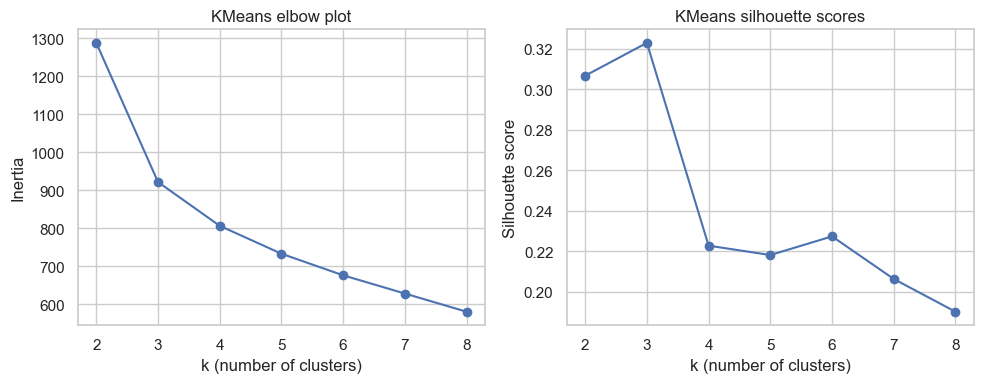

k=2: inertia=1287.4, silhouette=0.307
k=3: inertia=921.4, silhouette=0.323
k=4: inertia=806.2, silhouette=0.223
k=5: inertia=732.8, silhouette=0.218
k=6: inertia=676.0, silhouette=0.227
k=7: inertia=628.1, silhouette=0.206
k=8: inertia=580.3, silhouette=0.190

Chosen k (max silhouette): 3

=== CLUSTER COUNTS ===
cluster
0    77
1    86
2     7
Name: count, dtype: Int64


In [46]:
# Feature matrix
features = [
    "median_ts",
    "median_dt",
    "n_pairs",
    "median_len",
    "mean_spc",
    "std_spc",
    "avg_time_per_char",
    "prop_dt_lt_0p1",
    "prop_ts_gt_100",
    "ts_q99",
    "breakiness_ratio",
]
features = [c for c in features if c in df_clust.columns]

X = df_clust[features].copy()

# Log-transform heavy-tailed columns (keep prop_* as-is)
log_cols = [c for c in [
    "n_pairs", "median_dt", "median_ts",
    "mean_spc", "std_spc", "avg_time_per_char",
    "ts_q99", "breakiness_ratio"
] if c in X.columns]

for c in log_cols:
    X[c] = np.log1p(X[c])

# Cap extremes to avoid singleton clusters dominating (script monsters)
for c in X.columns:
    lo = X[c].quantile(0.005)
    hi = X[c].quantile(0.995)
    X[c] = X[c].clip(lo, hi)

# Clean NaN/inf and keep aligned df
X = X.replace([np.inf, -np.inf], np.nan).dropna()
df_use = df_clust.loc[X.index].copy()

print(f"Clustering on {len(df_use):,} sessions (dropped {len(df_clust)-len(df_use):,} due to NaN/inf).")
print("Features:", features)
print("Log1p:", log_cols)

# Standardise features so KMeans isn't biased by scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + silhouette over k
k_range = range(2, 9)
inertias, sil_scores, models = [], [], {}

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    models[k] = km
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot elbow + silhouette
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(list(k_range), inertias, marker="o")
ax[0].set_xlabel("k (number of clusters)")
ax[0].set_ylabel("Inertia")
ax[0].set_title("KMeans elbow plot")

ax[1].plot(list(k_range), sil_scores, marker="o")
ax[1].set_xlabel("k (number of clusters)")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("KMeans silhouette scores")

plt.tight_layout()
plt.savefig("output/kmeans_elbow_silhouette.png", dpi=150)
plt.show()

for k, inert, sil in zip(k_range, inertias, sil_scores):
    print(f"k={k}: inertia={inert:.1f}, silhouette={sil:.3f}")

best_k = k_range[int(np.argmax(sil_scores))]
print(f"\nChosen k (max silhouette): {best_k}")

# Fit final model + assign labels safely
kmeans = models[best_k]
df_use["cluster"] = kmeans.labels_

# Write back into df_clust aligned (no length mismatch)
df_clust["cluster"] = pd.NA
df_clust.loc[df_use.index, "cluster"] = df_use["cluster"].astype(int)
df_clust["cluster"] = df_clust["cluster"].astype("Int64")

print("\n=== CLUSTER COUNTS ===")
print(df_clust.loc[df_use.index, "cluster"].value_counts().sort_index())


Explained variance ratio: [0.46593601 0.19704031]


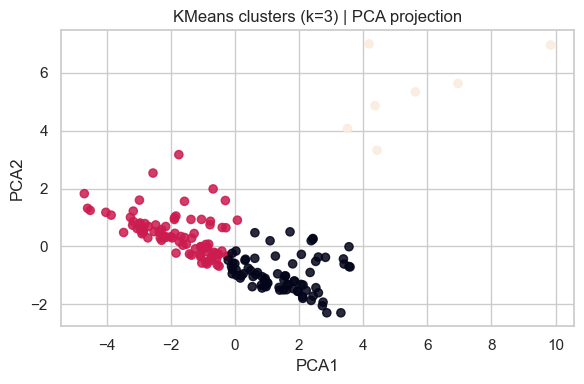

In [47]:
# PCA view for clustered rows only
assert "cluster" in df_clust.columns
pca = PCA(n_components=2, random_state=5)
X_pca = pca.fit_transform(X_scaled)

df_clust["PCA1"] = pd.NA
df_clust["PCA2"] = pd.NA
df_clust.loc[df_use.index, "PCA1"] = X_pca[:, 0]
df_clust.loc[df_use.index, "PCA2"] = X_pca[:, 1]

print("Explained variance ratio:", pca.explained_variance_ratio_)

# PCA scatter
plt.figure(figsize=(6, 4))

mask = df_clust["PCA1"].notna() & df_clust["PCA2"].notna() & df_clust["cluster"].notna()
plt.scatter(
    df_clust.loc[mask, "PCA1"].astype(float),
    df_clust.loc[mask, "PCA2"].astype(float),
    c=df_clust.loc[mask, "cluster"].astype(int),
    s=35,
    alpha=0.85,
)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title(f"KMeans clusters (k={best_k}) | PCA projection")
plt.tight_layout()
plt.savefig("output/kmeans_pca_scatter.png", dpi=150)
plt.show()

In [34]:
# Per-cluster descriptive stats
assert "cluster" in df_clust.columns, "df_clust must contain a 'cluster' column."

cols = [
    "median_ts","median_dt","prop_dt_lt_0p1","ts_q99","breakiness_ratio","n_pairs",
    "mean_ts","mean_dt","mean_len","std_len","mean_spc","median_spc","std_spc",
    "avg_time_per_char","session_duration_s",
]
cols = [c for c in cols if c in df_clust.columns and pd.api.types.is_numeric_dtype(df_clust[c])]

stats = df_clust.groupby("cluster")[cols].agg(["count","mean","std","min","max"])
stats.to_csv("output/cyberlab_kmeans_cluster_stats.csv")

sizes = df_clust["cluster"].value_counts().sort_values(ascending=False)
for k in sizes.index:
    print(f"\n--- Cluster {k} stats ---")
    for c in cols:
        n, mean, std, mn, mx = stats.loc[k, (c, "count")], stats.loc[k, (c, "mean")], stats.loc[k, (c, "std")], stats.loc[k, (c, "min")], stats.loc[k, (c, "max")]
        print(f"{c:18s}: n={int(n):5d}  mean={mean:8.4f}  std={std:8.4f}  min={mn:8.4f}  max={mx:8.4f}")

print("\nSaved: output/cyberlab_kmeans_cluster_stats.csv")



--- Cluster 1 stats ---
median_ts         : n=   86  mean=  0.6125  std=  0.2519  min=  0.1623  max=  1.5458
median_dt         : n=   86  mean= 29.6524  std= 15.3559  min=  8.8605  max=115.1898
prop_dt_lt_0p1    : n=   86  mean=  0.0024  std=  0.0094  min=  0.0000  max=  0.0741
ts_q99            : n=   86  mean=669.9797  std=3053.2897  min=  1.1124  max=17950.0000
breakiness_ratio  : n=   86  mean=  2.5037  std=  2.5512  min=  1.0000  max= 20.6523
n_pairs           : n=   86  mean= 43.9535  std= 23.4315  min=  6.0000  max=103.0000
mean_ts           : n=   86  mean= 31.4136  std=138.9717  min=  0.3062  max=792.1544
mean_dt           : n=   86  mean= 51.9749  std= 29.1231  min= 20.4615  max=260.7676
mean_len          : n=   86  mean= 18.5061  std=  6.5009  min=  9.5574  max= 42.3636
std_len           : n=   86  mean= 15.0090  std= 10.4372  min=  5.1241  max= 95.3176
mean_spc          : n=   86  mean=  4.9199  std=  1.8514  min=  1.9688  max= 10.0339
median_spc        : n=   86  mean=  1

## Cluster interpretation via z-scores (aligned with clustering features)

The table below reports **z-scores** for each clustering feature by cluster:

- A **z-score** is computed as:
  *(cluster mean − global mean) / global standard deviation*

Interpretation:
- **z > 0 (HIGH):** feature is above average in that cluster → characteristic feature
- **z < 0 (LOW):** feature is below average in that cluster → de-emphasised feature
- Larger |z| means the feature is more distinctive for that cluster.

### Summary
- **Cluster 0:** fast-paced, many command transitions, simpler/less punctuation-heavy commands
- **Cluster 1:** slower/more deliberate pacing, fewer transitions, more syntax-heavy commands
- **Cluster 2:** burst/paste/script-like behaviour (very high near-instant gaps + extreme speed tails), with longer commands and higher breakiness


In [37]:
# Cluster interpretation via z-scores (aligned with clustering features)

assert "cluster" in df_clust.columns, "df_clust must contain a 'cluster' column."
assert "features" in globals(), "Expected 'features' list from clustering cell."

features_for_z = [c for c in features if c in df_clust.columns and pd.api.types.is_numeric_dtype(df_clust[c])]

# Guard against degenerate std=0 columns
global_mean = df_clust[features_for_z].mean(numeric_only=True)
global_std  = df_clust[features_for_z].std(numeric_only=True).replace(0, np.nan)

cluster_means = df_clust.groupby("cluster")[features_for_z].mean(numeric_only=True)
cluster_z = (cluster_means - global_mean) / global_std

display(cluster_z.round(2))

for k, row in cluster_z.iterrows():
    top = row.abs().sort_values(ascending=False).head(5).index
    print(f"\n=== Cluster {k} - most distinctive features (z-scores) ===")
    for feat in top:
        z = row[feat]
        direction = "HIGH" if z > 0 else "LOW"
        print(f"  {feat:18s}: {direction:4s} (z={z:+.2f})")


,median_ts,median_dt,n_pairs,median_len,mean_spc,std_spc,avg_time_per_char,prop_dt_lt_0p1,prop_ts_gt_100,ts_q99,breakiness_ratio
cluster,,,,,,,,,,,
0,-0.07,-0.67,0.47,-0.28,-0.74,-0.67,-0.67,-0.18,-0.17,-0.14,0.24
1,-0.08,0.67,-0.50,0.17,0.73,0.64,0.66,-0.21,-0.21,-0.11,-0.28
2,1.80,-0.89,0.98,0.95,-0.82,-0.51,-0.79,4.51,4.47,2.92,0.79


Saved: output/cyberlab_kmeans_cluster_zscores.csv

=== Cluster 0 - most distinctive features (z-scores) ===
  mean_spc          : LOW  (z=-0.74)
  median_dt         : LOW  (z=-0.67)
  std_spc           : LOW  (z=-0.67)
  avg_time_per_char : LOW  (z=-0.67)
  n_pairs           : HIGH (z=+0.47)

=== Cluster 1 - most distinctive features (z-scores) ===
  mean_spc          : HIGH (z=+0.73)
  median_dt         : HIGH (z=+0.67)
  avg_time_per_char : HIGH (z=+0.66)
  std_spc           : HIGH (z=+0.64)
  n_pairs           : LOW  (z=-0.50)

=== Cluster 2 - most distinctive features (z-scores) ===
  prop_dt_lt_0p1    : HIGH (z=+4.51)
  prop_ts_gt_100    : HIGH (z=+4.47)
  ts_q99            : HIGH (z=+2.92)
  median_ts         : HIGH (z=+1.80)
  n_pairs           : HIGH (z=+0.98)


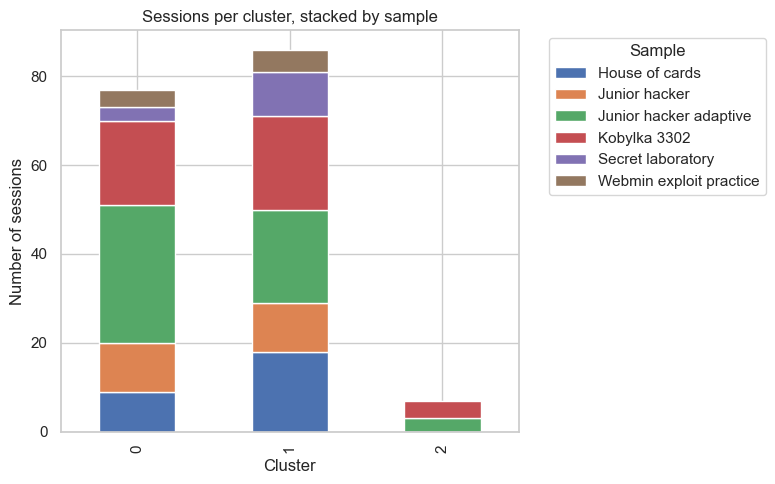

sample,House of cards,Junior hacker,Junior hacker adaptive,Kobylka 3302,Secret laboratory,Webmin exploit practice
cluster,,,,,,
0,0.117,0.143,0.403,0.247,0.039,0.052
1,0.209,0.128,0.244,0.244,0.116,0.058
2,0.000,0.000,0.429,0.571,0.000,0.000


In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Crosstab: cluster x sample
ct_counts = pd.crosstab(df_clust["cluster"], df_clust["sample"]).sort_index()

# display(ct_counts)

# Plot: stacked bar (counts)
plt.figure(figsize=(8, 5))
ct_counts.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)
plt.xlabel("Cluster")
plt.ylabel("Number of sessions")
plt.title("Sessions per cluster, stacked by sample")
plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

ct_props = ct_counts.div(ct_counts.sum(axis=1), axis=0)

display(ct_props.round(3))
